In [1]:
# in case there are any problems with importing because path is wrong
import sys
sys.path.append('/Users/daniel/Princeton Dropbox/Daniel Gurevich/Research/discrete_sr/code/SPIDER_discrete')

In [2]:
import numpy as np

from commons.weight import *
from commons.utils import save, load
from library import *
from process_library_terms import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
positions, vs, deltat, dims = load('Matt/sim_n1024.npy', 4)
deltat
print(positions.shape, vs.shape, deltat, dims)

Np, nt = positions.shape[0], positions.shape[2]
world_size = np.array([dims[0], dims[0], dims[1]])
print(world_size)

(1024, 2, 128) (1024, 2, 128) 0.0041432037960149265 [  1 128]
[  1   1 128]


0
0
0
0
10
20
30
40
50
60
70
80
90
100
110
120


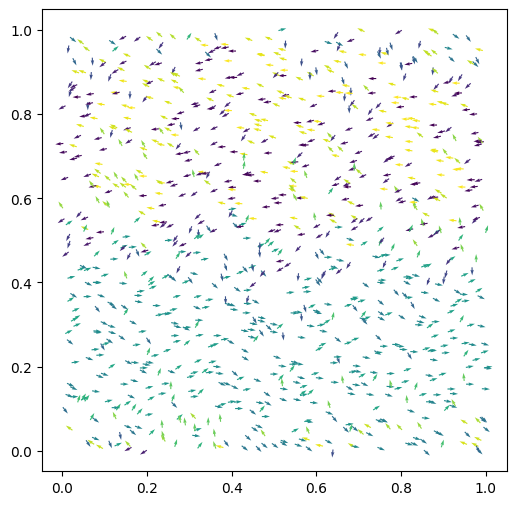

In [4]:
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/Users/daniel/Documents/ffmpeg-7.1/ffmpeg'

vid_file = 'Matt/sim_n1024.mp4'

fig, ax = plt.subplots(figsize=(6, 6))
qv = ax.quiver(positions[:, 0, -1], positions[:, 1, -1], 1, 0, clim=[-np.pi, np.pi])

def animate(i):
    if i % 10 == 0:
        print(i)
    qv.set_offsets(positions[:, :, i])
    norms = np.sqrt(vs[:, 0, i] ** 2 + vs[:, 1, i] ** 2)
    qv.set_UVC(vs[:, 0, i] / norms, vs[:, 1, i] / norms, np.angle(vs[:, 0, i] + 1.0j * vs[:, 1, i]))
    return qv,

anim = FuncAnimation(fig, animate, np.arange(0, positions.shape[-1]), interval=1, blit=True)
FFwriter = animation.FFMpegWriter(fps=24, codec="libx264")
anim.save(vid_file, writer=FFwriter, dpi=100)

In [5]:
%%prun # profiling

data_dict = {}
data_dict['v'] = vs
v_obs = Observable(string='v', rank=1)
observables = [v_obs]

# fix random seed
np.random.seed(1)

# initial setup of dataset
corr_L = 0.05
kernel_sigma = 0.05 # 0.02
cg_res = 256
srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
                irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
v_est = np.mean(np.abs(vs))*2**0.5
print(v_est)

# initialize libraries, domains, and weights
#srd.make_libraries(max_complexity=4, max_observables=3, max_rho=2)
srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
#srd.make_libraries(max_complexity=6, max_observables=4)

dom_width = 0.3
dom_time = 40
#srd.make_domains(ndomains=3, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
srd.make_domains(ndomains=30, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
srd.make_weights(m=8, qmax=0)
srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
srd.make_library_matrices(debug=False)

save('Q_gauss1024.npy', srd)

0.8146324564354405
 

         16888067 function calls (16215381 primitive calls) in 978.745 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4260  733.511    0.172  733.533    0.172 coarse_grain_utils.py:267(poly_coarse_grain_time_slices)
      973  141.269    0.145  141.325    0.145 {built-in method time.sleep}
    26640   47.422    0.002  889.909    0.033 process_library_terms.py:400(eval_term)
    18180   18.687    0.001   18.707    0.001 diff.py:479(_apply_to_array)
   237/15   11.219    0.047    0.001    0.000 {method 'control' of 'select.kqueue' objects}
    79920    4.287    0.000    5.811    0.000 _function_base_impl.py:5078(trapezoid)
    26640    1.842    0.000  913.623    0.034 process_library_terms.py:378(eval_on_domain)
    79920    1.680    0.000    1.747    0.000 polynomial.py:672(polyval)
     4260    1.636    0.000  841.254    0.197 process_library_terms.py:90(eval_prime)
   201709    1.623    0.000    1.623    0.000 {metho

In [6]:
# %%prun # profiling

# data_dict = {}
# data_dict['v'] = vs
# v_obs = Observable(string='v', rank=1)
# observables = [v_obs]

# # fix random seed
# np.random.seed(1)

# # initial setup of dataset
# corr_L = 0.05#0.3
# kernel_sigma = 0.02#0.05
# cg_res = 256
# srd = SRDataset(world_size=world_size, data_dict=data_dict, particle_pos=positions, observables=observables, 
#                 irreps=SRDataset.all_rank2_irreps(), kernel_sigma=kernel_sigma, cg_res=cg_res, deltat=deltat, cutoff=6)
# v_est = np.mean(np.abs(vs))*2**0.5
# print(v_est)

# # initialize libraries, domains, and weights
# #srd.make_libraries(max_complexity=4, max_observables=3, max_rho=2)
# srd.make_libraries(max_complexity=5, max_observables=3, max_rho=2)
# #srd.make_libraries(max_complexity=6, max_observables=4)

# dom_width = 0.3
# dom_time = 20
# srd.make_domains(ndomains=15, domain_size=[dom_width, dom_width, dom_time], pad=kernel_sigma*4) #*8
# srd.make_weights(m=8, qmax=1)
# srd.set_LT_scale(L=corr_L, T=corr_L/v_est) # note that this line must go before make_library_matrices
# srd.make_library_matrices(debug=False)

# save('Q_gauss1024.npy', srd.dxs, srd.libs)

In [15]:
from commons.identify_models import *
import copy

#srd = load('Q_gauss1024.npy', 1)
libs = srd.libs

reg_opts_list = []
for irrep in srd.irreps:
    # for regression we now need to construct a Scaler, Initializer, ModelIterator, and Threshold
    scaler = Scaler(sub_inds=None, char_sizes=libs[irrep].col_weights, row_norms=None, unit_rows=True, train_fraction=0.8)
    #init = Initializer(method='combinatorial', start_k=2)
    init = Initializer(method='combinatorial', start_k=9999)
    #init = Initializer(method='power', start_k=10)
    #res = Residual(residual_type='fixed_column', anchor_col=0)
    res = Residual(residual_type='dominant_balance')
    #res = Residual(residual_type='matrix_relative')
    
    #iterator = ModelIterator(max_k=10, backward_forward=True, max_passes=10)
    iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=True, max_passes=1)
    thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
    #thres = Threshold(threshold_type='information', ic=AIC)
    
    opts = {'scaler': scaler, 'initializer': init, 'residual': res,
            'model_iterator': iterator, 'threshold': thres}
    opts['verbose'] = False
    opts['inhomog'] = False
    opts['inhomog_col'] = None
    reg_opts_list.append(opts)

eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in srd.irreps], 
#eqs, lambdas, reg_results, derived_eqs, excluded_terms = interleave_identify([libs[i] for i in range(len(irreps))], 
reg_opts_list, threshold=3e-1, experimental=True)
#, max_equations=10)

--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 1 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 2 ---
[0.00 s]
Identified model: ρ + -0.000977 · ρ · ρ = 0 (order 2, train res 1.36e-02, test res 1.25e-02)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Antisymmetric rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Symmetric trace-free rank 2 AT COMPLEXITY 2 ---
--- WORKING ON LIBRARY WITH IRREP Rank 0 AT COMPLEXITY 3 ---
[0.00 s]
Identified model: ∂t ρ + 1 · ∂α ρ[v_α] = 0 (order 3, train res 1.73e-06, test res 1.67e-06)
--- WORKING ON LIBRARY WITH IRREP Rank 1 AT COMPLEXITY 3 ---
[0.00 s]
Identified model: -0.000979 · ρ · ρ[v_α] + ρ[v_α] = 0 (order 3, train res 1.93e-02, test res 1.45e-02)
--- W

In [8]:
print(excluded_terms)

{ρ · ρ · ρ · ρ[v_α], ∂t² ∂α² ρ, ρ · ∂α ρ · ∂β ρ, ρ · ∂α ρ · ρ[v_β], ∂t ∂α ρ · ρ[v_α], ∂α ρ[v_α], ρ · ρ · ∂α ρ, ∂t ∂α ∂β ρ[v_β], ∂α ρ[v_α · v_β · v_β], ρ · ρ · ∂α² ρ, ρ[v_α] · ∂β ρ[v_β], ρ · ρ · ρ[v_α · v_β], ∂t ∂α ρ[v_β · v_β], ∂α ρ · ρ[v_β · v_β], ρ[v_α] · ρ[v_β · v_β], ∂t ρ · ρ[v_α · v_α], ρ · ρ[v_α] · ρ[v_α], ρ · ∂α ρ[v_β], ρ[v_β] · ∂α ρ[v_β], ∂α ∂β² ρ, ∂α ρ[v_β · v_β], ρ · ∂α ρ[v_β · v_γ], ρ · ρ · ∂t ∂α ρ, ρ[v_α · v_β] · ρ[v_β], ∂t ∂α² ρ, ρ · ∂α² ρ, ∂α² ∂β ρ[v_β], ρ · ρ · ∂t ρ[v_α], ρ · ρ · ρ[v_α · v_α], ∂α² ∂β² ρ, ρ · ρ · ∂α ρ[v_β], ρ · ρ · ρ · ρ, ∂α ∂β² ρ[v_α], ρ[v_α] · ∂t ρ[v_α], ρ · ∂t² ρ, ρ · ρ · ∂α ∂β ρ, ∂α² ρ[v_β · v_β], ∂α ∂β ∂γ ρ[v_γ], ρ · ∂α ∂β ρ, ρ · ρ · ρ · ∂t ρ, ρ · ∂t ∂α ∂β ρ, ρ · ∂t ∂α ρ, ρ · ∂t ρ · ρ[v_α], ρ · ρ · ρ[v_α], ρ · ∂t ρ[v_α], ρ · ρ[v_α · v_β · v_β], ∂α ∂β ∂γ² ρ, ρ · ∂t³ ρ, ρ · ρ[v_α · v_β], ρ · ∂α ρ, ρ · ∂α ρ · ∂α ρ, ρ · ρ[v_α], ρ · ∂α ρ[v_α], ρ · ∂t² ρ[v_α], ρ · ∂t ρ[v_α · v_α], ρ · ∂t ∂α ρ[v_β], ∂t ρ · ∂α ρ[v_α], ρ · ∂t ρ · ∂t ρ, ρ · ρ · ∂t ρ, ρ · ∂α ∂β

In [9]:
lib1 = libs[srd.irreps[1]]
for i, term, size in zip(list(range(len(lib1.terms))), lib1.terms, lib1.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib1.terms, r'∂t ρ\[v_α\]')))
print(next(regex_find(lib1.terms, r'ρ · ∂t ρ\[v_α\]')))

0 ρ · ∂α ρ 648599.3994675716 3
1 ρ · ∂α ∂β² ρ 259439759.7870286 5
2 ρ · ∂t ∂α ρ 10567402.440616388 4
3 ρ · ∂t² ∂α ρ 172170980.16682395 5
4 ρ · ρ[v_α] 736613.6385961184 3
5 ρ · ∂β² ρ[v_α] 9112685.463582328 5
6 ρ · ∂α ∂β ρ[v_β] 9112685.463582328 5
7 ρ · ∂t ρ[v_α] 371174.4671960802 4
8 ρ · ∂t² ρ[v_α] 6047415.359561173 5
9 ρ · ∂β ρ[v_α · v_β] 320078.29650456115 5
10 ρ · ∂α ρ[v_β · v_β] 320078.29650456115 5
11 ρ · ρ[v_α · v_β · v_β] 363512.576202532 5
12 ∂α ρ 633.3978510425504 2
13 ∂α ρ · ∂β² ρ 8023856.754106417 5
14 ∂β ρ · ∂α ∂β ρ 8023856.754106417 5
15 ∂α ρ · ∂t ρ 326824.70688419056 4
16 ∂α ρ · ∂t² ρ 5324840.2758572195 5
17 ∂β ρ · ∂α ρ[v_β] 281833.75927049486 5
18 ∂α ρ · ∂β ρ[v_β] 281833.75927049486 5
19 ∂β ρ · ∂β ρ[v_α] 281833.75927049486 5
20 ∂β ρ · ρ[v_α · v_β] 320078.29650456127 5
21 ∂α ρ · ρ[v_β · v_β] 320078.29650456127 5
22 ∂β² ρ · ρ[v_α] 9112685.46358233 5
23 ∂α ∂β ρ · ρ[v_β] 9112685.46358233 5
24 ∂α ∂β² ρ 253359.14041702013 4
25 ∂t ρ · ∂t ∂α ρ 5324840.2758572195 5
26 ∂t ρ · ρ[v_α

In [10]:
lib0 = libs[srd.irreps[0]]
for i, term, size in zip(list(range(len(lib0.terms))), lib0.terms, lib0.col_weights):
    print(i, term, size, term.complexity)
print(next(regex_find(lib0.terms, r'∂α² ρ')))
print(next(regex_find(lib0.terms, r'∂t² ρ')))
print(next(regex_find(lib0.terms, r'∂t ∂α ρ\[v_α\]')))
print(next(regex_find(lib0.terms, r'ρ · ∂α² ρ')))

0 ρ 1024.0 1
1 ρ · ρ 1048576.0 2
2 ρ · ∂α² ρ 12971987.98935143 4
3 ρ · ∂t ρ 528370.1220308194 3
4 ρ · ∂t ∂α² ρ 211348048.81232774 5
5 ρ · ∂t² ρ 8608549.008341199 4
6 ρ · ∂t³ ρ 140256068.5001973 5
7 ρ · ∂α ρ[v_α] 455634.2731791165 4
8 ρ · ∂t ∂α ρ[v_α] 7423489.343921604 5
9 ρ · ρ[v_α · v_α] 517463.35274297046 4
10 ρ · ∂t ρ[v_α · v_α] 260746.16893318194 5
11 ∂α ρ · ∂α ρ 401192.8377053209 4
12 ∂α ρ · ∂t ∂α ρ 6536494.137683812 5
13 ∂α ρ · ρ[v_α] 455634.2731791165 4
14 ∂α ρ · ∂t ρ[v_α] 229590.92762095784 5
15 ∂α² ρ 12667.957020851007 3
16 ∂α² ρ · ∂t ρ 6536494.137683812 5
17 ∂α² ∂β² ρ 5067182.808340403 5
18 ∂t ρ 515.9864472957221 2
19 ∂t ρ · ∂t ρ 266242.013792861 4
20 ∂t ρ · ∂t² ρ 4337787.714047936 5
21 ∂t ρ · ∂α ρ[v_α] 229590.9276209578 5
22 ∂t ρ · ρ[v_α · v_α] 260746.168933182 5
23 ∂t ∂α ρ · ρ[v_α] 7423489.343921604 5
24 ∂t ∂α² ρ 206394.5789182888 4
25 ∂t² ρ 8406.786140958202 3
26 ∂t² ∂α² ρ 3362714.4563832795 5
27 ∂t³ ρ 136968.81689472392 4
28 ∂t⁴ ρ 2231584.8752401 5
29 ρ[v_α] · ρ[v_α] 5174

In [11]:
print(reg_results[2].all_lambdas, reg_results[2].all_lambdas_test)

[1.412 0.019 0.019 0.018 0.018] [0.738 0.007 0.007 0.008 0.008]


In [19]:
scaler = Scaler(sub_inds=None, char_sizes=lib0.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
#init = Initializer(method='combinatorial', start_k=2)
init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
res = Residual(residual_type='dominant_balance')
#res = Residual(residual_type='matrix_relative')

#iterator = ModelIterator(max_k=10, backward_forward=True, brute_force=True, max_passes=10)
iterator = ModelIterator(max_k=len(libs[irrep].terms), backward_forward=True, max_passes=1)
thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 15 # ∂α² ρ
opts['verbose']=True
#opts['inhomog_col'] = 25 # ∂t² ρ

#remove_terms = [7] # rho * dt rho[v_i]
remove_terms = [34, 2] # ∂t ∂α ρ[v_α], ρ · ∂α² ρ
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib0.Q, **opts)
zipped = [(lib0.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)

Checking single-term residuals...
nrm[0]: 0.7397519565196419
nrm[1]: 0.7404641919626934
nrm[2]: 0.39581307570207425
nrm[3]: 1.2808189508885515
nrm[4]: 1.5240678685544402
nrm[5]: 5.479022174772821
nrm[6]: 0.458999167030384
nrm[7]: 1.7673589355403727
nrm[8]: 1.1351536760300176
nrm[9]: 6.4653759991954995
nrm[10]: 2.340438848437614
nrm[11]: 0.8145573885051351
nrm[12]: 0.2816549423367321
nrm[13]: 4.913352185793485
nrm[14]: 0.9779033779916502
nrm[15]: 1.1159321232899226
nrm[16]: 3.5190499065040033
nrm[17]: 0.39753840435567483
nrm[18]: 3.8047754544947994
nrm[19]: 1.8277552275672844
nrm[20]: 4.412195170429666
nrm[21]: 0.6543636579644422
nrm[22]: 0.5046134303176745
nrm[23]: 1.2892228845167637
nrm[24]: 1.5234031080045563
nrm[25]: 4.046334282516278
nrm[26]: 5.446566678794887
nrm[27]: 24.33602656299491
nrm[28]: 0.6298343334674836
nrm[29]: 2.394606667985541
nrm[30]: 0.4609999298068635
nrm[31]: 1.495030165974186
nrm[32]: 1.495030165974186
nrm[33]: 6.316019785186464
nrm[34]: 1.1323719893209756
nrm[35

In [ ]:
scaler = Scaler(sub_inds=None, char_sizes=lib1.col_weights, row_norms=None, train_fraction=1, unit_rows=True)
init = Initializer(method='combinatorial', start_k=2)
#init = Initializer(method='combinatorial', start_k=9999)
#init = Initializer(method='power', start_k=10)
#res = Residual(residual_type='fixed_column', anchor_col=0)
res = Residual(residual_type='dominant_balance')
#res = Residual(residual_type='matrix_relative')

iterator = ModelIterator(max_k=10, backward_forward=True, brute_force=True, max_passes=10)
thres = Threshold(threshold_type='jump', gamma=1.5, delta=1e-8, n_terms=None)
#thres = Threshold(threshold_type='information', ic=AIC)

opts = {'scaler': scaler, 'initializer': init, 'residual': res,
        'model_iterator': iterator, 'threshold': thres}

opts['inhomog'] = True
opts['inhomog_col'] = 41 # dt rho[v_i]

remove_terms = [7] # rho * dt rho[v_i]
for term in remove_terms:
    if term in opts['scaler'].sub_inds:
        opts['scaler'].sub_inds.remove(term) 
opts['scaler'].reset_inds(opts['scaler'].sub_inds)

reg_result = sparse_reg_bf(lib1.Q, **opts)
zipped = [(lib1.terms[i], c) for i, c in enumerate(reg_result.xi) if c != 0]
eqn = Equation([e[0] for e in zipped], [e[1] for e in zipped])

print(eqn, "; residual:", reg_result.lambd)

In [ ]:
continuity_terms = ['dt rho', 'dj rho[v_j]']
#continuity_terms = ['1', 'rho', 'rho * rho']
#continuity_terms = ['rho * rho[v_j * v_j]', 'rho[v_j] * rho[v_j]', 'rho']
#continuity_terms = ['rho * dt rho', 'rho * dj rho[v_j]']
#continuity_terms = ['dt rho * rho', 'rho * rho * dj v_j', 'dj rho * rho * v_j']
#continuity_terms = ['dt rho', 'dj rv_j']
col_numbers = [find_term(libs[0].terms, name) for name in continuity_terms]
Xi, lambd = regress(libs[0].Q, col_numbers)
for i in range(len(Xi)):
    if Xi[i]!=0:
        print(f"[Term {i}] {Xi[i]} * {libs[0].terms[i]}. (Char. size: {libs[0].col_weights[i]})")
print("Model residual:", lambd)